# Image Classification
数据集来自 [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) 
## Get the Data
首先运行下载数据集 [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/cifar/cifar-10-python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()



All files found!


## Explore the Data
数据集被分成批以防止您的机器内存不足。 CIFAR-10数据集由5个批次组成，分别命名为data_batch_1，data_batch_2等。每个批次包含下列标签和图像中的一个：
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

理解数据集是对数据进行预测的一部分。 通过改变`batch_id`和`sample_id`来改变下面的代码单元。 `batch_id`是批次（1-5）的ID。 `sample_id`是批次中图像和标签对的标识。



Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


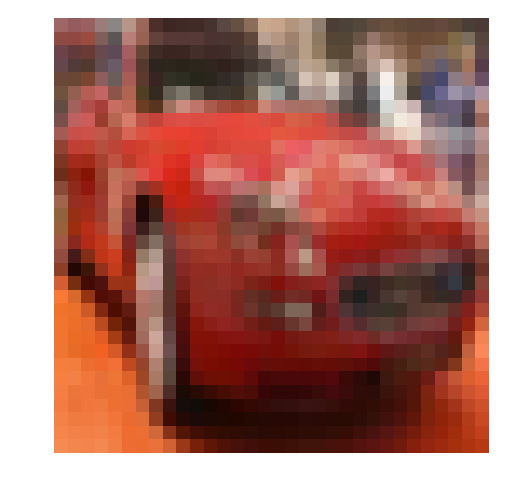

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
归一化使x的数值在0-1之间

In [5]:
import numpy as np
def normalize(x):
    
    
    y = (x - np.min(x))/(np.max(x)=np.min(x))
    
    return y



Tests Passed


### One-hot encode
实现`one_hot_encode`函数。 输入“x”是一个标签列表。 实现函数将标签列表返回为一个热编码的Numpy数组, 标签的可能值是0到9.

In [6]:
from sklearn import preprocessing
import numpy as np
def one_hot_encode(x):

    lb = preprocessing.LabelBinarizer()
    lb.fit([0,1,2,3,4,5,6,7,8,9])
    return lb.transform(x)


Tests Passed


### Randomize Data
本次样本已经随机化。

## Preprocess all the data and save it
运行代码单元将预处理所有CIFAR-10数据并将其保存到文件中。 下面的代码也使用了10％的训练数据进行验证。

In [7]:

helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
重启时从此运行即可。

In [8]:

import pickle
import problem_unittests as tests
import helper

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
构建网络

### Input
输入

In [9]:
import tensorflow as tf

def neural_net_image_input(image_shape):

    W = tf.placeholder(dtype=tf.float32, shape=[None, image_shape[0], image_shape[1], image_shape[2]], name='x')
    return W


def neural_net_label_input(n_classes):

    Y = tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name='y')
    return Y


def neural_net_keep_prob_input():

    keep_prob_input = tf.placeholder(dtype=tf.float32, name='keep_prob')
    return keep_prob_input




Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
构建卷积池化层

In [10]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):


    #直接tensor的shape类型是Dimension 必须要转成list 用as_list
    depth = x_tensor.get_shape().as_list()[3]

    weights = tf.Variable(tf.truncated_normal(stddev=0.1,shape=[conv_ksize[0], conv_ksize[1], depth,conv_num_outputs]),dtype=tf.float32)
    biases = tf.Variable(tf.truncated_normal([conv_num_outputs]),dtype=tf.float32)
    conv = tf.nn.conv2d(x_tensor, weights,[1,conv_strides[0], conv_strides[1], 1], 'SAME')
    conv = tf.nn.bias_add(conv, biases)
    conv = tf.nn.relu(conv)
    pool = tf.nn.max_pool(conv, [1, pool_ksize[0], pool_ksize[1], 1], [1, pool_strides[0],pool_strides[1], 1], 'SAME')
    
    return pool 



   




Tests Passed


### Flatten Layer
平铺上层的输出，使输出和全连接层的输入维度相同

In [11]:
def flatten(x_tensor):

    flattened_image_size = np.prod(x_tensor.get_shape().as_list()[1:])
    flat_inputs = tf.reshape(x_tensor,[-1,flattened_image_size])

    
    return flat_inputs


Tests Passed


### Fully-Connected Layer
全连接层

In [12]:
def fully_conn(x_tensor, num_outputs):
###注意，一定要设置W的sttdev方差值，用默认值或许使权重初始化错误
    x_size_list=x_tensor.get_shape().as_list()
    weight=tf.Variable(tf.truncated_normal(stddev=0.1,shape=[x_size_list[1],num_outputs]),dtype=tf.float32)
    bias=tf.Variable(tf.zeros([num_outputs]),dtype=tf.float32)
    out = tf.matmul(x_tensor, weight)
    out = tf.add(out, bias)
    out = tf.nn.relu(out)
    return out


Tests Passed


### Output Layer
输出层

In [13]:
def output(x_tensor, num_outputs):

    image_shape = x_tensor.get_shape().as_list()
    weights = tf.Variable(tf.truncated_normal([image_shape[1], num_outputs],0,0.01),dtype=tf.float32)
    bias = tf.Variable(tf.zeros([num_outputs]), dtype=tf.float32)
    outputs = tf.add(tf.matmul(x_tensor, weights),bias)
    return outputs


Tests Passed


### Create Convolutional Model
创建卷积模型

In [17]:
def conv_net(x, keep_prob):

    conv_ksize=(2,2)
    conv_strides=(2,2)
    pool_ksize=(2,2)
    pool_strides=(2,2)
    conv_maxpool1 = conv2d_maxpool(x, 120, conv_ksize, (1,1), pool_ksize, pool_strides)
    conv_maxpool1 = tf.nn.dropout(conv_maxpool1, keep_prob)
    conv_maxpool2 = conv2d_maxpool(conv_maxpool1, 300, conv_ksize, (1,1), pool_ksize, pool_strides)
    conv_maxpool2 = tf.nn.dropout(conv_maxpool2, keep_prob)
    conv_maxpool3 = conv2d_maxpool(conv_maxpool2, 128,conv_ksize, conv_strides, pool_ksize, pool_strides)

    output_conv = flatten(conv_maxpool3)

    fc1 = fully_conn(output_conv, 384)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    fc2 = fully_conn(fc1, 128)
    #fc2 = tf.nn.dropout(fc2, keep_prob)

    output_final = output(fc2, 10)
    
    

    return output_final




tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
实现函数`train_neural_network`来做一次优化。 优化应该使用`optimizer`来优化`session`中的`feed_dict`如下：
*`x`用于图像输入
*‘y’是标签值
*`keep_prob`dropout概率

这个函数将被调用，因此`tf.global_variables_initializer（）`已经被调用。

不需要返回。 这个功能只是优化神经网络。

In [18]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):

    
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob:keep_probability})
    

Tests Passed


### Show Stats
显示统计
打印和验证的loss损失和准确性。 使用全局变量`valid_features`和`valid_labels`来计算验证的准确性。 使用keepout概率“1.0”来计算损失和验证的准确性。

In [19]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):

    loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.0})
    valid_accur = session.run(accuracy, feed_dict={x:valid_features, y:valid_labels, keep_prob: 1.})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,valid_accur))
    

### Hyperparameters
超参数的设置

In [21]:

epochs = 100
batch_size = 128
keep_probability = 0.8

### Train on a Single CIFAR-10 Batch
在单一的CIFAR-10批次上训练
而不是在所有CIFAR-10批次的数据上训练神经网络，让我们使用一个批次。 这样在迭代模型时可以节省时间，以获得更好的精度。 一旦最终验证准确度达到某一个好的值，再在所有数据上运行模型。

In [18]:

print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle 
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.3001 Validation Accuracy: 0.115200
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.2690 Validation Accuracy: 0.176400
Epoch  3, CIFAR-10 Batch 1:  Loss:     2.2160 Validation Accuracy: 0.233400
Epoch  4, CIFAR-10 Batch 1:  Loss:     2.1825 Validation Accuracy: 0.260400
Epoch  5, CIFAR-10 Batch 1:  Loss:     2.1503 Validation Accuracy: 0.269000
Epoch  6, CIFAR-10 Batch 1:  Loss:     2.1242 Validation Accuracy: 0.304200
Epoch  7, CIFAR-10 Batch 1:  Loss:     2.1032 Validation Accuracy: 0.322200
Epoch  8, CIFAR-10 Batch 1:  Loss:     2.0586 Validation Accuracy: 0.332400
Epoch  9, CIFAR-10 Batch 1:  Loss:     2.0156 Validation Accuracy: 0.354400
Epoch 10, CIFAR-10 Batch 1:  Loss:     1.8822 Validation Accuracy: 0.372800
Epoch 11, CIFAR-10 Batch 1:  Loss:     1.7624 Validation Accuracy: 0.379600
Epoch 12, CIFAR-10 Batch 1:  Loss:     1.6899 Validation Accuracy: 0.406000
Epoch 13, CIFAR-10 Batch 1:  Loss:     1.6351

### Fully Train the Model
在整个训练集上训练。

In [22]:

save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2948 Validation Accuracy: 0.112400
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.1222 Validation Accuracy: 0.235600
Epoch  1, CIFAR-10 Batch 3:  Loss:     2.0203 Validation Accuracy: 0.234200
Epoch  1, CIFAR-10 Batch 4:  Loss:     2.0777 Validation Accuracy: 0.259600
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.9579 Validation Accuracy: 0.315800
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.0731 Validation Accuracy: 0.348000
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.9451 Validation Accuracy: 0.359800
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.5896 Validation Accuracy: 0.384600
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.7206 Validation Accuracy: 0.381600
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.8295 Validation Accuracy: 0.400200
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.7768 Validation Accuracy: 0.426200
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.6920 Validation Accuracy: 0.436600
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.3886 Validation Accuracy: 0.434000


Epoch 22, CIFAR-10 Batch 4:  Loss:     0.2366 Validation Accuracy: 0.629000
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.2124 Validation Accuracy: 0.627000
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.2897 Validation Accuracy: 0.619000
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.2534 Validation Accuracy: 0.611800
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.2033 Validation Accuracy: 0.627800
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.2389 Validation Accuracy: 0.628000
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.2181 Validation Accuracy: 0.627200
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.2386 Validation Accuracy: 0.620000
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.3079 Validation Accuracy: 0.635000
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.2227 Validation Accuracy: 0.625800
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.2023 Validation Accuracy: 0.623400
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.1627 Validation Accuracy: 0.642200
Epoch 25, CIFAR-10 Batch 1:  Loss:     0.2397 Validation Accuracy: 0.624400
Epoch 25, CI

Epoch 44, CIFAR-10 Batch 2:  Loss:     0.0487 Validation Accuracy: 0.626400
Epoch 44, CIFAR-10 Batch 3:  Loss:     0.0426 Validation Accuracy: 0.628800
Epoch 44, CIFAR-10 Batch 4:  Loss:     0.0506 Validation Accuracy: 0.637400
Epoch 44, CIFAR-10 Batch 5:  Loss:     0.0331 Validation Accuracy: 0.639000
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.0765 Validation Accuracy: 0.635000
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.0411 Validation Accuracy: 0.620400
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.0743 Validation Accuracy: 0.623600
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.0443 Validation Accuracy: 0.639000
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.0323 Validation Accuracy: 0.642000
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.0399 Validation Accuracy: 0.627800
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.0438 Validation Accuracy: 0.617400
Epoch 46, CIFAR-10 Batch 3:  Loss:     0.0326 Validation Accuracy: 0.625600
Epoch 46, CIFAR-10 Batch 4:  Loss:     0.0442 Validation Accuracy: 0.629200
Epoch 46, CI

Epoch 65, CIFAR-10 Batch 5:  Loss:     0.0119 Validation Accuracy: 0.643400
Epoch 66, CIFAR-10 Batch 1:  Loss:     0.0294 Validation Accuracy: 0.641200
Epoch 66, CIFAR-10 Batch 2:  Loss:     0.0162 Validation Accuracy: 0.638400
Epoch 66, CIFAR-10 Batch 3:  Loss:     0.0165 Validation Accuracy: 0.644600
Epoch 66, CIFAR-10 Batch 4:  Loss:     0.0087 Validation Accuracy: 0.643200
Epoch 66, CIFAR-10 Batch 5:  Loss:     0.0172 Validation Accuracy: 0.640000
Epoch 67, CIFAR-10 Batch 1:  Loss:     0.0136 Validation Accuracy: 0.637800
Epoch 67, CIFAR-10 Batch 2:  Loss:     0.0186 Validation Accuracy: 0.633200
Epoch 67, CIFAR-10 Batch 3:  Loss:     0.0135 Validation Accuracy: 0.635000
Epoch 67, CIFAR-10 Batch 4:  Loss:     0.0153 Validation Accuracy: 0.642400
Epoch 67, CIFAR-10 Batch 5:  Loss:     0.0165 Validation Accuracy: 0.646600
Epoch 68, CIFAR-10 Batch 1:  Loss:     0.0093 Validation Accuracy: 0.639800
Epoch 68, CIFAR-10 Batch 2:  Loss:     0.0103 Validation Accuracy: 0.643800
Epoch 68, CI

Epoch 87, CIFAR-10 Batch 3:  Loss:     0.0051 Validation Accuracy: 0.644200
Epoch 87, CIFAR-10 Batch 4:  Loss:     0.0191 Validation Accuracy: 0.644400
Epoch 87, CIFAR-10 Batch 5:  Loss:     0.0225 Validation Accuracy: 0.648200
Epoch 88, CIFAR-10 Batch 1:  Loss:     0.0238 Validation Accuracy: 0.644600
Epoch 88, CIFAR-10 Batch 2:  Loss:     0.0070 Validation Accuracy: 0.635200
Epoch 88, CIFAR-10 Batch 3:  Loss:     0.0091 Validation Accuracy: 0.643800
Epoch 88, CIFAR-10 Batch 4:  Loss:     0.0150 Validation Accuracy: 0.649200
Epoch 88, CIFAR-10 Batch 5:  Loss:     0.0116 Validation Accuracy: 0.647000
Epoch 89, CIFAR-10 Batch 1:  Loss:     0.0074 Validation Accuracy: 0.634000
Epoch 89, CIFAR-10 Batch 2:  Loss:     0.0079 Validation Accuracy: 0.637400
Epoch 89, CIFAR-10 Batch 3:  Loss:     0.0163 Validation Accuracy: 0.649600
Epoch 89, CIFAR-10 Batch 4:  Loss:     0.0054 Validation Accuracy: 0.650400
Epoch 89, CIFAR-10 Batch 5:  Loss:     0.0064 Validation Accuracy: 0.642000
Epoch 90, CI


## Test Model
根据测试数据集测试模型。

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6493275316455697



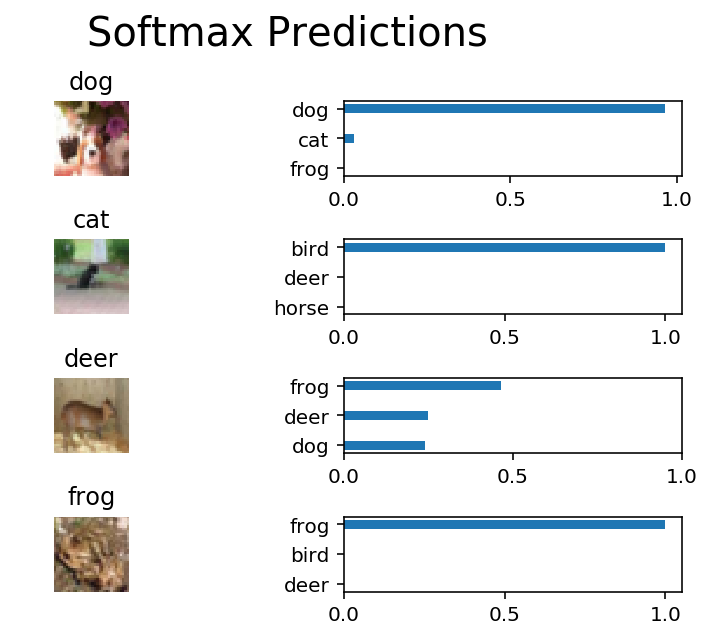

In [25]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()